In [1]:
import os
import json
import numpy as np
import argparse
import matplotlib.pyplot as plt
import japanize_matplotlib
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

In [20]:
RESULT_DIR = "/home/user/workspace/Master_Thesis/results/GUMI_AE_2/False_False_False_0_32_4_31_128_128_25_32_0.0001_16384_25_64_0.0001_1024/"
AE_RESULT_DIR = "/home/user/workspace/Master_Thesis/results/Autoencoder/False_False_False_0_32_4_31_128_128_25_32_0.0001_16384/"

with open(f"{RESULT_DIR}index_to_word.json", "r") as f:
    index_to_word = json.load(f)
index_to_word = {
    int(K): V for K, V in index_to_word.items()
}

In [4]:
class BokeGeneratorModel(nn.Module):
    def __init__(self, num_word, image_feature_dim, sentence_length, feature_dim = 1024):
        """
            num_word: 学習に用いる単語の総数
            image_feature_dim: 画像の特徴量の次元数
            sentence_length: 入力する文章の単語数
            feature_dim: 特徴量次元数
        """
        super(BokeGeneratorModel, self).__init__()
        self.num_word = num_word
        self.image_feature_dim = image_feature_dim
        self.sentence_length = sentence_length
        self.feature_dim = feature_dim
        
        self.fc1 = nn.Linear(image_feature_dim, feature_dim)
        self.embedding = nn.Embedding(num_word, feature_dim, padding_idx = 0)
        self.lstm = nn.LSTM(input_size = feature_dim, hidden_size = feature_dim, 
                            batch_first = True)
        self.fc2 = nn.Linear(feature_dim + feature_dim, 2 * feature_dim)
        self.fc3 = nn.Linear(2 * feature_dim, 2 * feature_dim)
        self.fc4 = nn.Linear(2 * feature_dim, num_word)
    
    # LSTMの初期値は0で，画像の特徴量と文章の特徴量を全結合層の前で結合する
    def forward(self, image_features, sentences):
        """
            image_features: 画像の特徴量
            sentences: 入力する文章
        """
        x1 = F.leaky_relu(self.fc1(image_features))
        x1 = x1.unsqueeze(1).repeat(1, self.sentence_length, 1)

        x2 = self.embedding(sentences)
        x2, _ = self.lstm(x2)

        x = torch.cat((x1, x2), dim = -1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))

        return self.fc4(x)

class ImageEncoder(nn.Module):
    def __init__(self, image_feature_dim):
        """
            image_feature_dim: 
        """
        super(ImageEncoder, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)

        self.fc1 = nn.Linear(16384, 16384)
        self.fc2 = nn.Linear(16384, image_feature_dim)
    
    def forward(self, images):
        x = F.leaky_relu( self.conv1(images) )
        # 32, 64, 64
        x = F.leaky_relu( self.conv2(x) )
        # 64, 32, 32
        x = F.leaky_relu( self.conv3(x) )
        # 128, 16, 16
        x = F.leaky_relu( self.conv4(x) )
        # 256, 8, 8

        x = nn.Flatten()(x)
        x = F.leaky_relu(self.fc1(x))
        return F.leaky_relu(self.fc2(x))

class ImageDecoder(nn.Module):
    def __init__(self, image_feature_dim):
        """
            image_feature_dim: 
        """
        super(ImageDecoder, self).__init__()

        self.fc1 = nn.Linear(image_feature_dim, 16384)

        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.deconv4 = nn.ConvTranspose2d(32, 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        
        self.conv1 = nn.Conv2d(32, 3, kernel_size = 3, stride = 1, padding = 1)
    
    def forward(self, image_features):
        x = F.leaky_relu(self.fc1(image_features))
        x = nn.Unflatten(1, (256, 8, 8))(x)
        # 256, 8, 8

        x = F.leaky_relu( self.deconv1(x) )
        # 128, 16, 16
        x = F.leaky_relu( self.deconv2(x) )
        # 64, 32, 32
        x = F.leaky_relu( self.deconv3(x) )
        # 32, 64, 64
        x = F.leaky_relu( self.deconv4(x) )
        # 32, 128, 128
        return nn.Sigmoid()( self.conv1(x) )
        # 3, 128, 128

class Autoencoder(nn.Module):
    def __init__(self, image_feature_dim):
        """
            image_feature_dim: 
        """
        super(Autoencoder, self).__init__()

        self.encoder = ImageEncoder(image_feature_dim)
        self.decoder = ImageDecoder(image_feature_dim)
    
    def forward(self, images):
        return self.decoder( self.encoder(images) )

class GUMI_AE:
    def __init__(self, weight_path, ae_weight_path, index_to_word, sentence_length, feature_dim = 1024, image_height = 128, image_width = 128, ae_feature_dim = 16384):
        """
            weight_path: 大喜利適合判定モデルの学習済みの重みのパス
            ae_weight_path:
            index_to_word: 単語のID: 単語の辞書(0:<PAD>, 1:<START>, 2:<END>)
            sentence_length: 入力する文章の単語数
            feature_dim: 特徴量次元数
            ae_feature_dim:
        """
        self.index_to_word = index_to_word
        self.sentence_length = sentence_length

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.boke_generate_model = BokeGeneratorModel(
                                        num_word = len(index_to_word),
                                        image_feature_dim = ae_feature_dim,
                                        sentence_length = sentence_length,
                                        feature_dim = feature_dim)
        self.boke_generate_model.load_state_dict(torch.load(weight_path))
        self.boke_generate_model.to(self.device)
        self.boke_generate_model.eval()

        self.autoencoder = Autoencoder(image_feature_dim = ae_feature_dim)
        self.autoencoder.load_state_dict(torch.load(ae_weight_path))
        self.encoder = self.autoencoder.encoder
        self.encoder = self.encoder.to(self.device)
        self.encoder.eval()

        # 画像の前処理
        self.image_preprocesser = transforms.Compose([
            transforms.Resize((image_height, image_width)),
            transforms.ToTensor(),
        ])

    def __call__(self, image_path, argmax = False, top_k = 5):
        """
            image_path: 大喜利を生成したい画像のパス
            argmax: Trueなら最大確率の単語を選ぶ, FalseならTop-Kサンプリングを行う
            top_k: Top-Kサンプリング時に考慮する単語の数
        """
        image = Image.open(image_path)
        preprocessed_image = self.image_preprocesser(image).to(self.device)
        image_feature = self.encoder( preprocessed_image.unsqueeze(0) ) # (1, 2048)

        generated_text = [1] # <START>トークン
        for i in range(1, self.sentence_length):
            tmp = generated_text + [0] * (self.sentence_length - i) # Padding
            tmp = torch.Tensor(np.array(tmp)).unsqueeze(0).to(self.device).to(dtype=torch.int32) # (1, sentence_length)
            pred = self.boke_generate_model(image_feature, tmp) # (1, sentence_length, num_word)
            target_pred = pred[0][i - 1]

            if argmax:
                # 最大確率の単語を選ぶ
                chosen_id = torch.argmax(target_pred).item()
            else:
                # Top-Kサンプリング
                top_k_probs, top_k_indices = torch.topk(target_pred, top_k)
                top_k_probs = torch.nn.functional.softmax(top_k_probs / 0.5, dim = -1)
                chosen_id = np.random.choice(top_k_indices.detach().cpu().numpy(),
                                             p = top_k_probs.detach().cpu().numpy())

            generated_text.append(chosen_id)
            if chosen_id == 2:
                break

        generated_sentence = ""
        for I in generated_text[1:-1]:
            generated_sentence += self.index_to_word[I]
        return generated_sentence

In [21]:
gumi_ae = GUMI_AE(weight_path = f"{RESULT_DIR}best_model.pth",
                  ae_weight_path = f"{AE_RESULT_DIR}best_model.pth",
                          index_to_word = index_to_word,
                          sentence_length = 32)

<ipython-input-4-44c8dab28ec1>:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.boke_generate_model.load_state_dict(torch.load(weight_path))
<ipython-input-4-44c8dab2

'「お前は虎の子どもは認めたいのか？」'

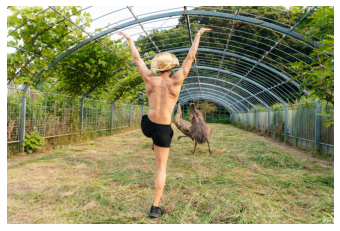

In [24]:
image_path = "/home/user/workspace/Master_Thesis/Master_Thesis_programs/image_1.jpg"

fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(Image.open(image_path))
ax.axis("off")

gumi_ae(image_path)